In [1]:
import sys
import os
script_dir = os.getcwd() # coleata o diretorio do projeto atual
sys.path.append(script_dir)

In [2]:
import cv2
import numpy as np

In [3]:
# Função para carregar imagens de uma pasta
def carregar_imagens_pasta(base_path, target_size=(224, 224)):
    imagens = []
    labels = []
    
    # Percorre cada classe (pastas de classe)
    for classe in os.listdir(base_path):
        classe_path = os.path.join(base_path, classe, 'images')  # Caminho da pasta images
        
        # Verifica se é uma pasta válida
        if os.path.isdir(classe_path):
            # Percorre cada imagem dentro da pasta de imagens
            for img_name in os.listdir(classe_path):
                img_path = os.path.join(classe_path, img_name)
                
                # Carrega a imagem usando cv2
                img = cv2.imread(img_path)
                
                # Verifica se a imagem foi carregada corretamente
                if img is not None:
                    # Redimensiona a imagem
                    img_resized = cv2.resize(img, target_size)
                    
                    # Normaliza a imagem (opcional: normalize entre [0, 1])
                    img_normalized = img_resized / 255.0
                    
                    # Adiciona a imagem e o label (nome da classe) à lista
                    imagens.append(img_normalized)
                    labels.append(classe)
    
    return np.array(imagens), np.array(labels)

# Carregar imagens de treino
train_path = 'Data/Train'
X_train, y_train = carregar_imagens_pasta(train_path)

# Carregar imagens de validação
val_path = 'Data/Val'
X_val, y_val = carregar_imagens_pasta(val_path)


In [4]:
# Visualizar a quantidade de imagens carregadas
print(f"Total de imagens de treino: {len(X_train)}")
print(f"Total de imagens de validação: {len(X_val)}")
print(f"Total de classes: {set(y_val)}")

Total de imagens de treino: 4737
Total de imagens de validação: 512
Total de classes: {'No Tumor', 'Pituitary', 'Glioma', 'Meningioma'}


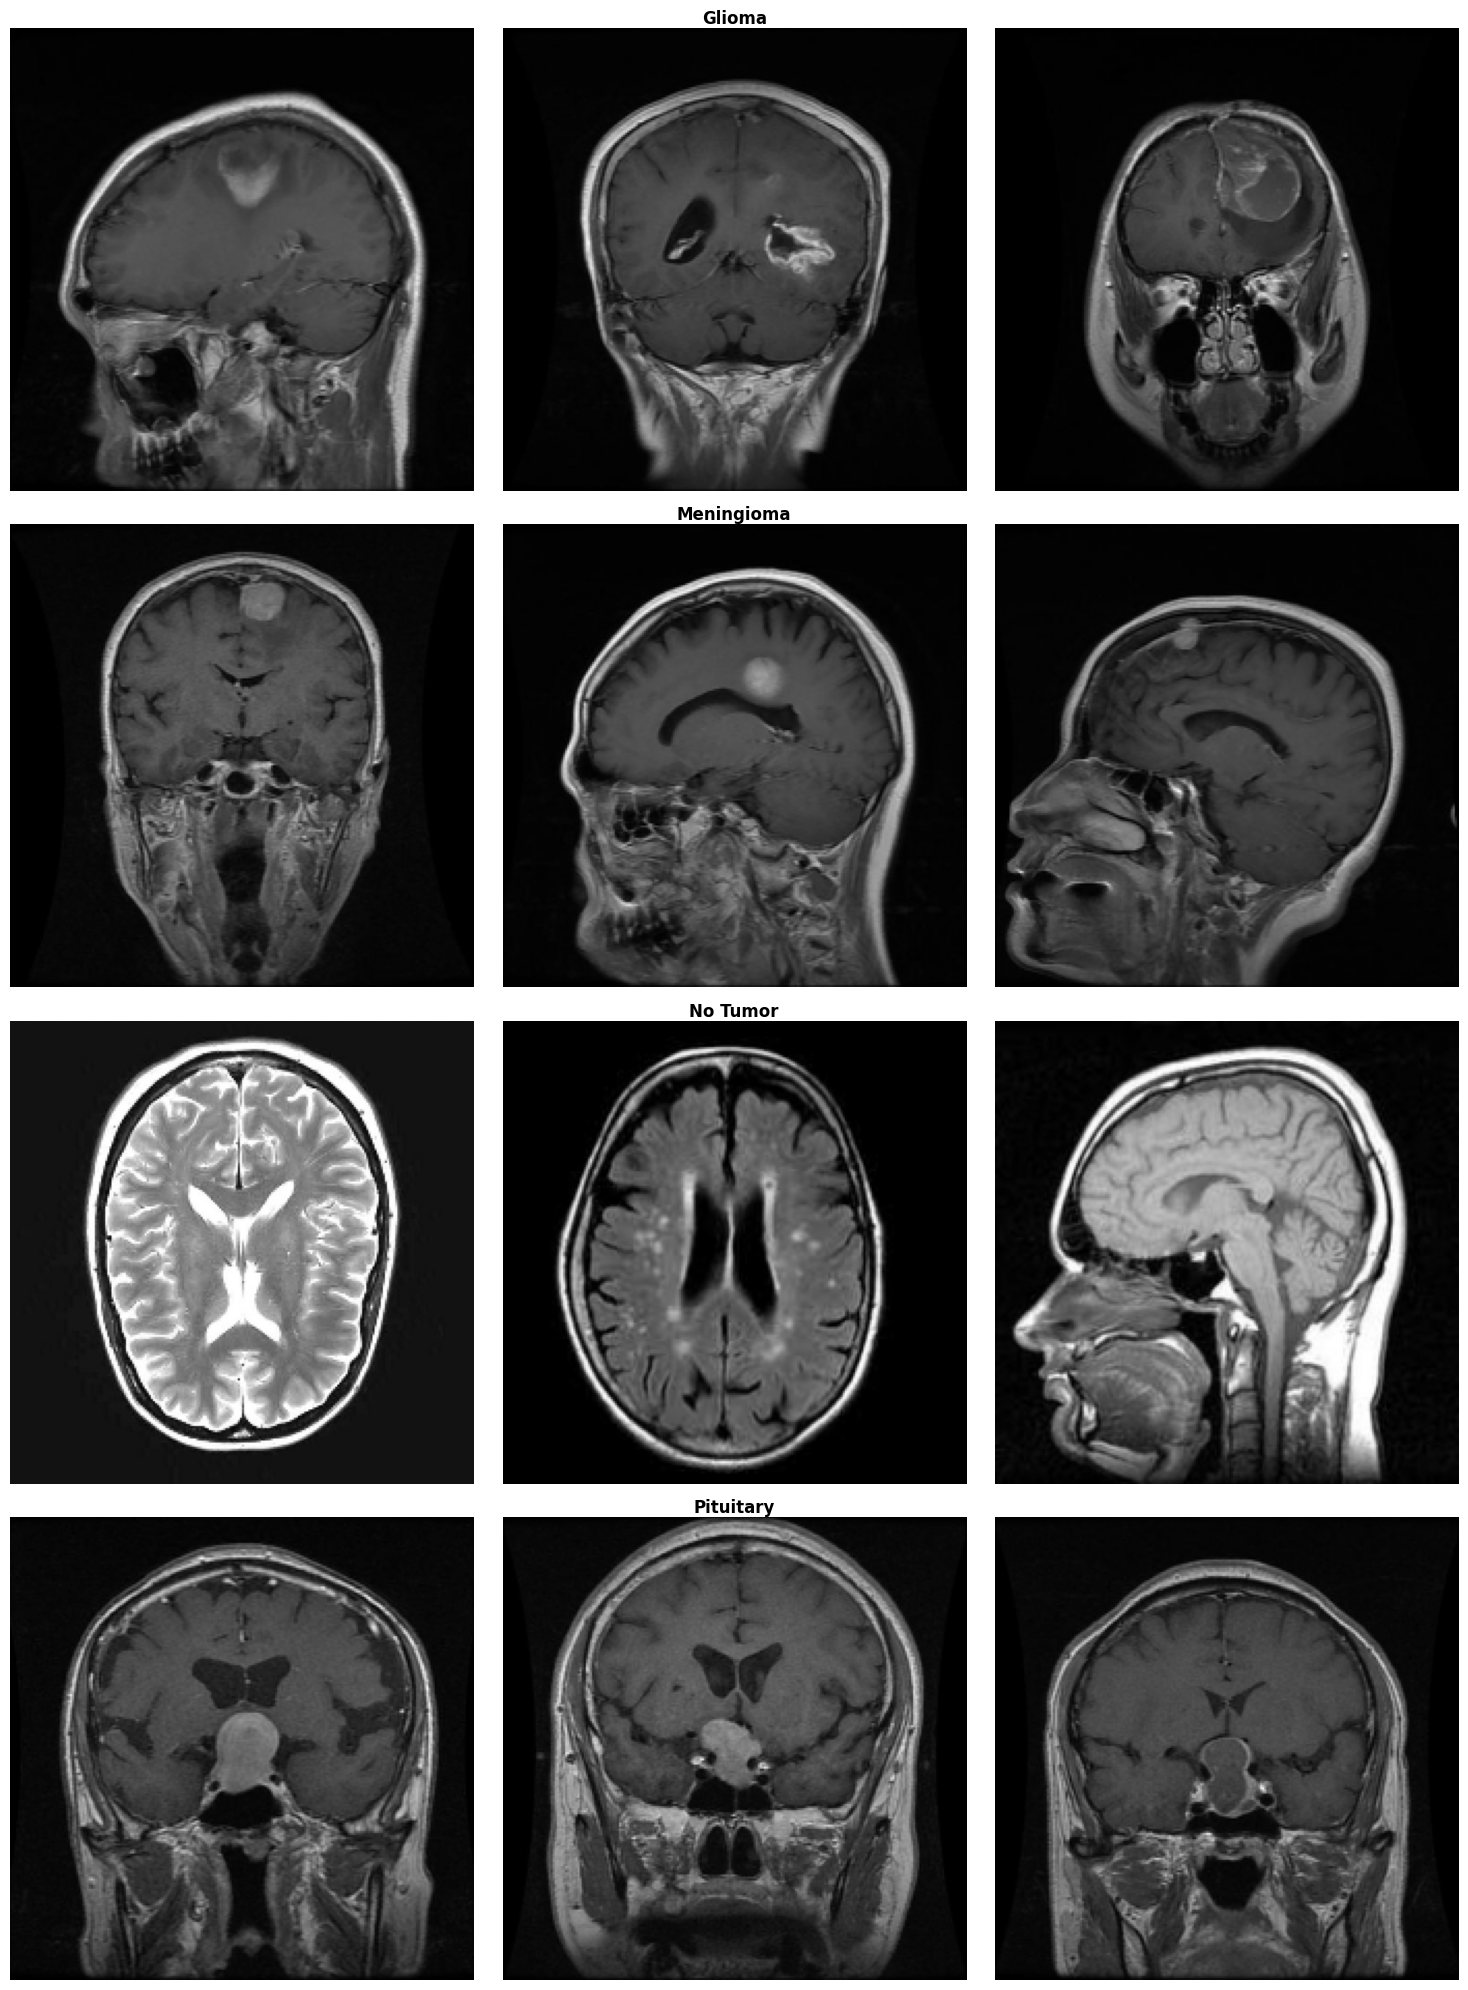

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def mostrar_exemplos(imagens, labels, classes, num_exemplos=3):
    # Configura a visualização
    fig, axes = plt.subplots(len(classes), num_exemplos, figsize=(15, 5 * len(classes)))
    
    for i, classe in enumerate(classes):
        # Filtra imagens da classe atual
        indices = np.where(labels == classe)[0]
        exemplos = np.random.choice(indices, num_exemplos, replace=False)
        
        for j, idx in enumerate(exemplos):
            img = imagens[idx]
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
        
        # Adiciona o título no centro da coluna da classe
        ax_title = axes[i, num_exemplos // 2]
        ax_title.set_title(f'{classe}', fontsize=12, fontweight='bold', ha='center', va='center')
        ax_title.axis('off')
    
    plt.tight_layout()
    plt.show()

# Supondo que você já carregou as imagens e rótulos
# Classes devem ser as labels únicas presentes no seu dataset
classes = np.unique(y_train)
mostrar_exemplos(X_train, y_train, classes)


In [6]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# 1. Codificação das Classes
# Codificar os rótulos de classe em números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# One-hot encoding dos rótulos
num_classes = len(np.unique(y_train_encoded))
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)

# 2. Construir o Modelo CNN
model = Sequential([
    # Camada convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    # Camada convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Camada convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Camada de flattening
    Flatten(),
    
    # Camada densa
    Dense(128, activation='relu'),
    
    # Camada de saída com softmax
    Dense(num_classes, activation='softmax')
])

# 3. Compilar o Modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Treinar o Modelo
history = model.fit(
    X_train, y_train_one_hot,
    epochs=5,  # Número de épocas, ajuste conforme necessário
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

# 5. Avaliar o Modelo
val_loss, val_accuracy = model.evaluate(X_val, y_val_one_hot)
print(f'Perda de Validação: {val_loss}')
print(f'Precisão de Validação: {val_accuracy}')


c:\Users\vinic\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 121s 789ms/step - accuracy: 0.5675 - loss: 1.1233 - val_accuracy: 0.7129 - val_loss: 0.6880
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 98s 650ms/step - accuracy: 0.8511 - loss: 0.3638 - val_accuracy: 0.8477 - val_loss: 0.3832
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 95s 638ms/step - accuracy: 0.9193 - loss: 0.2109 - val_accuracy: 0.9238 - val_loss: 0.2756
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 101s 673ms/step - accuracy: 0.9803 - loss: 0.0614 - val_accuracy: 0.9004 - val_loss: 0.3243
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 143s 677ms/step - accuracy: 0.9872 - loss: 0.0394 - val_accuracy: 0.9297 - val_loss: 0.2376
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - accuracy: 0.8734 - loss: 0.3955
Perda de Validação: 0.23756064474582672
Precisão de Validação: 0.9296875


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step


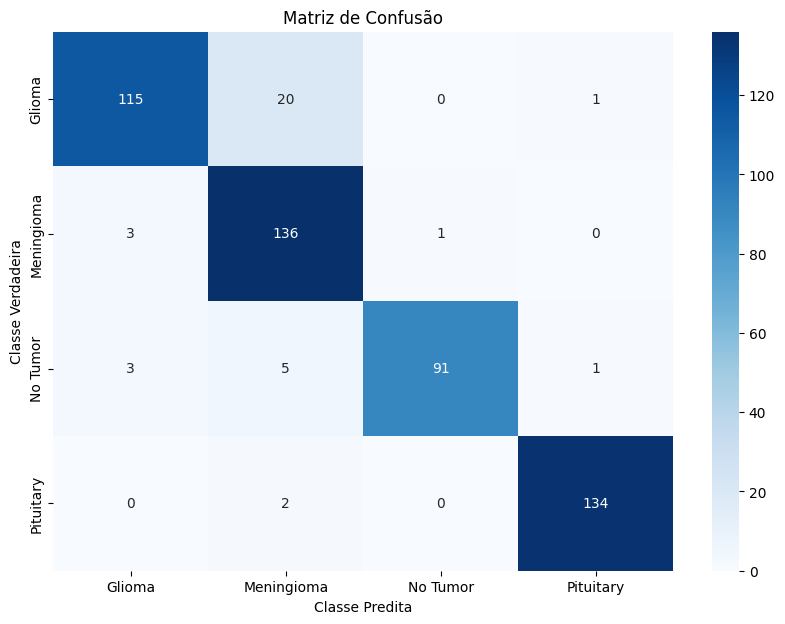

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Fazer previsões usando o modelo
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertendo as previsões em classes
y_true = np.argmax(y_val_one_hot, axis=1)   # Convertendo os rótulos one-hot em classes

# 2. Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 3. Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()


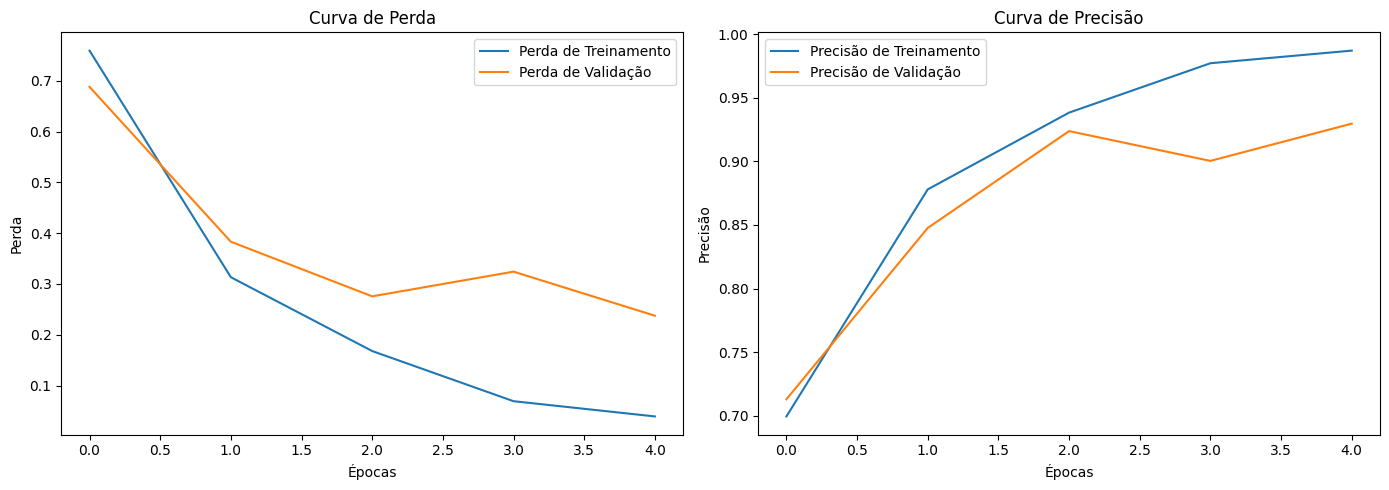

In [9]:
import matplotlib.pyplot as plt

# 1. Plotar a curva de perda
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Curva de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# 2. Plotar a curva de precisão
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisão de Treinamento')
plt.plot(history.history['val_accuracy'], label='Precisão de Validação')
plt.title('Curva de Precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.tight_layout()
plt.show()
